In [3]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('data/trainData.csv')
data.head()

,PassengerId,HomePlanet,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,VIP,CryoSleep,Deck,Room,Info
0,0001_01,2,1,39.0,0,0,0,0,0,0,0,0,2,0,1
1,0002_01,1,1,24.0,109,9,25,549,44,1,0,0,6,0,2
2,0003_01,2,1,58.0,43,3576,0,6715,49,0,1,0,1,0,2
3,0003_02,2,1,33.0,0,1283,371,3329,193,0,0,0,1,0,2
4,0004_01,1,1,16.0,303,70,151,565,2,1,0,0,6,1,2


In [4]:
features = ['HomePlanet', 'Destination', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'VIP', 'CryoSleep', 'Deck', 'Room', 'Info']
X, Y = data[features], data['Transported']
 

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

X.shape, Y.shape

(torch.Size([8693, 13]), torch.Size([8693]))

In [5]:
# 制作torch dataset, 3:7划分训练集和验证集
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)

train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
from model.BinaryClassification import BinaryClassification
import matplotlib.pyplot as plt

In [16]:
model = BinaryClassification(input_dim=len(features))

# 定义损失函数
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)

print(model)

BinaryClassification(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [17]:
# 指定学习率计划 lr = 1e-8 * 10^(epoch/n)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=10)
lr_set = []
train_losses, val_losses = [], []
epochs = 200

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y.view(-1, 1))
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
    lr_set.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}")


Epoch 0 train loss: 0.6950888980121512, val loss: 0.6955038236408699
Epoch 10 train loss: 0.6950985739368418, val loss: 0.695503789477232
Epoch 20 train loss: 0.6950207287104342, val loss: 0.6955035001766391
Epoch 30 train loss: 0.69499804274574, val loss: 0.6955011050875594
Epoch 40 train loss: 0.6949910799246184, val loss: 0.6954950755689202
Epoch 50 train loss: 0.6949793609024967, val loss: 0.6954553926863322
Epoch 60 train loss: 0.6949634648742476, val loss: 0.695380159994451
Epoch 70 train loss: 0.6945599186482854, val loss: 0.6949949686120196
Epoch 80 train loss: 0.6939694659872205, val loss: 0.6943024120679716
Epoch 90 train loss: 0.6903176061145923, val loss: 0.6910012335312076
Epoch 100 train loss: 0.6838567996524392, val loss: 0.6823544480451723
Epoch 110 train loss: 0.4736819639411896, val loss: 0.4832035350363429
Epoch 120 train loss: 0.4386405027349582, val loss: 0.4452767045032687
Epoch 130 train loss: 0.40989697978134554, val loss: 0.42674264384479055
Epoch 140 train los

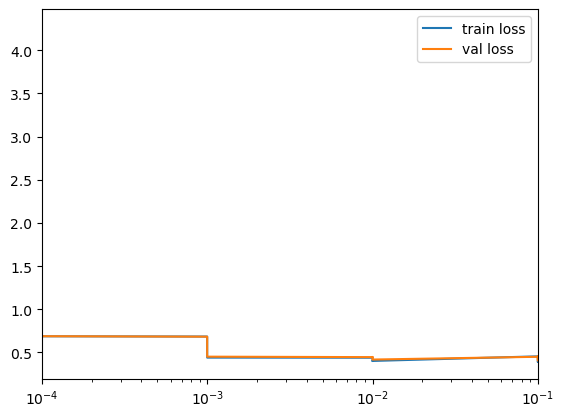

In [19]:
plt.plot(lr_set, train_losses, label='train loss')
plt.plot(lr_set, val_losses, label='val loss')
plt.xscale('log')
plt.xlim(1e-4, 1e-1)
plt.legend()
plt.show()